In [1]:
# Import necessary libraries
import torch
import torchvision
from torchvision.datasets import ImageFolder,KMNIST
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
import numpy as np

In [38]:
# Loading dataset
batch_size = 50
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((240,240)), 
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((240,240)), 
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    transforms.Normalize(mean, std)
])

train_data = torchvision.datasets.EMNIST(
    root=".",
    split="letters",
    train=True,
    download=True,
    transform = train_transform)

test_data = torchvision.datasets.EMNIST(
    root=".",
    split="letters",
    train=False,
    download=True,
    transform = test_transform)

# Initialize EMINST train and test data loaders. 
emnist_train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)
emnist_test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)
print(train_data)
print(len(train_data.classes))
print(test_data)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(240, 240), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Lambda()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
27
Dataset EMNIST
    Number of datapoints: 20800
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(240, 240), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Lambda()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 240, 240])


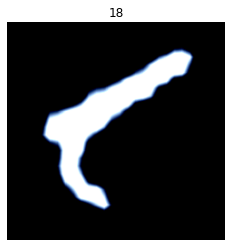

In [40]:
# Visualize an image and its label
image, label = train_data[np.random.randint(len(train_data))]
print(image.size())
plt.axis('off')
# If running this cell gives you error regarding image size please try this:
# plt.imshow(image.permute(1,2,0).squeeze(2), cmap='gray')
plt.imshow(image.permute(1,2,0))
plt.title(label)
plt.show()

In [41]:
# Checking if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Load MobileNet V3 small
mobilenet_v3_small = torchvision.models.mobilenet_v3_small(pretrained=True)
mobilenet_v3_small.eval()
# Freeze the weights
for param in mobilenet_v3_small.parameters():
    param.requires_grad = False
# Modify the last layer
number_features = mobilenet_v3_small.classifier[3].in_features
features = list(mobilenet_v3_small.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, 27)])
mobilenet_v3_small.classifier = torch.nn.Sequential(*features)

mobilenet_v3_small.to(device)
print(mobilenet_v3_small)


cuda
MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), s

In [47]:
# Load SqueezeNet
squeezenet = torchvision.models.squeezenet1_0(pretrained=True)
squeezenet.eval()
# Freeze the weights
for param in squeezenet.parameters():
    param.requires_grad = False
# Modify the classification layers
squeezenet.classifier[1] = torch.nn.Conv2d(512, 27, kernel_size=(1,1), stride=(1,1))
squeezenet.to(device)
print(squeezenet)
squeezenet.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [51]:
# Load ShuffleNet
shufflenet = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
shufflenet.eval()
# Freeze the weights
for param in shufflenet.parameters():
    param.requires_grad = False
in_features = shufflenet.fc.in_features
shufflenet.fc = torch.nn.Linear(in_features, 27, bias=True)
print(shufflenet)
shufflenet.to(device)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [53]:
# Load EfficientNet baseline
efficientnet_b0 = torchvision.models.efficientnet_b0(pretrained=True)
efficientnet_b0.eval()
# Freeze the weights
for param in efficientnet_b0.parameters():
    param.requires_grad = False
in_features = efficientnet_b0.classifier[1].in_features
efficientnet_b0.classifier[1] = torch.nn.Linear(in_features, 27, bias=True)
print(efficientnet_b0) 
efficientnet_b0.to(device)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [58]:
# Load ResNet18
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.eval()
for param in resnet18.parameters():
    param.requires_grad = False
in_features = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(in_features, 27, bias=True)
print(resnet18)
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
criterion = torch.nn.CrossEntropyLoss()
def Train(model,optimizer,dataloader,device):
    loss_tracker = []
    accuracy_tracker = []
    for i,(data,label) in enumerate(dataloader):
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        outputs = model.forward(data)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        if i % batch_size:
            print(f'step: {i+1}, loss = {loss.item():.4f}')
            with torch.no_grad():
                loss_tracker.append(loss.item())
                value, predictions = torch.max(outputs,1)
#                 print(f'Predictions: {predictions}')
#                 print(f'Labels: {label}')
                correct_prediction = 0
                correct_prediction += (predictions == label).sum().item()
                accuracy = correct_prediction / label.shape[0] * 100
                accuracy_tracker.append(accuracy)
            
    return loss_tracker, accuracy_tracker

def Test(model,dataloader,device):
    loss_tracker = []
    accuracy_tracker = []
    for i,(data,label) in enumerate(dataloader):
        data = data.to(device)
        label = label.to(device)
        with torch.no_grad():
            outputs = model.forward(data)
            loss = criterion(outputs, label)
            _, predictions = torch.max(outputs,1)
            correct_prediction = 0
            correct_prediction += (predictions == label).sum().item()
            accuracy = correct_prediction / label.shape[0] * 100
            
        loss_tracker.append(loss.item())
        accuracy_tracker.append(accuracy)
        
    return sum(loss_tracker)/len(loss_tracker), sum(accuracy_tracker)/len(accuracy_tracker)

In [59]:
epochs = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(mobilenet_v3_small.parameters(), lr = learning_rate)
model = resnet18

train_loss_tracker = []
train_accuracy_tracker = []

test_loss_tracker = []
test_accuracy_tracker = []

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    train_loss,train_accuracy = Train(model,optimizer,emnist_train_loader,device)
    test_loss , test_accuracy = Test(model,emnist_test_loader,device)
    train_loss_tracker.extend(train_loss)
    train_accuracy_tracker.extend(train_accuracy)
    test_loss_tracker.append(test_loss)
    test_accuracy_tracker.append(test_accuracy)
    print('\t training loss/accuracy: {0:.2f}/{1:.2f}'.format(sum(train_loss)/len(train_loss), sum(train_accuracy)/len((train_accuracy))))
    print('\t testing loss/accuracy: {0:.2f}/{1:.2f}'.format(test_loss, test_accuracy))

Epoch: 0
step: 2, loss = 3.4080
step: 3, loss = 3.1815
step: 4, loss = 3.2623
step: 5, loss = 3.3284
step: 6, loss = 3.3376
step: 7, loss = 3.2681
step: 8, loss = 3.3138
step: 9, loss = 3.3769
step: 10, loss = 3.3340
step: 11, loss = 3.2669
step: 12, loss = 3.4097
step: 13, loss = 3.3883
step: 14, loss = 3.4200
step: 15, loss = 3.3487
step: 16, loss = 3.2639
step: 17, loss = 3.3064
step: 18, loss = 3.3128
step: 19, loss = 3.3522
step: 20, loss = 3.1823
step: 21, loss = 3.2817
step: 22, loss = 3.3697
step: 23, loss = 3.2390
step: 24, loss = 3.4151
step: 25, loss = 3.3999
step: 26, loss = 3.2865
step: 27, loss = 3.1922
step: 28, loss = 3.2934
step: 29, loss = 3.4622
step: 30, loss = 3.3027
step: 31, loss = 3.2915
step: 32, loss = 3.2458
step: 33, loss = 3.3968
step: 34, loss = 3.3076
step: 35, loss = 3.1907
step: 36, loss = 3.4097
step: 37, loss = 3.2832
step: 38, loss = 3.3942
step: 39, loss = 3.4192
step: 40, loss = 3.3124
step: 41, loss = 3.3960
step: 42, loss = 3.4811
step: 43, loss 

KeyboardInterrupt: 